**Airbnb Calendar -Time-Series Analysis**

# Introduction



## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [21]:
#Read in libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import fbprophet
from fbprophet.plot import plot_plotly

import sklearn

**Read in Data**

In [2]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed/'

#Read in Airbnb Calendar listings data
bookings_df = pd.read_csv(path + '2020_0417_Booked_Listings.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

#Read in Airbnb Calendar prices data
income_df = pd.read_csv(path + '2020_0417_Daily_Net_Rental_Income.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

**Set notebook preferences**

In [3]:
#Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###Set plot aesthetics for notebook###
#Style
plt.style.use('Solarize_Light2')

#Title dictionary
title_dict = {'fontsize':16,
             'fontweight': 'bold'}
#Label dictionary
label_dict = {'fontsize':12,
             'fontweight': 'bold'}

# Data Overview

## Preview Airbnb Booked Listings Data

In [4]:
#Preview listings data
display(bookings_df.head())

,count
date,
2018-10-03,5897
2018-10-04,5806
2018-10-05,5847
2018-10-06,5822
2018-10-07,5493


## Data Information

In [5]:
#View listings info
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 2018-10-03 to 2020-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   546 non-null    int64
dtypes: int64(1)
memory usage: 8.5+ KB


In [6]:
#Describe listings_df
bookings_df.describe()

,count
count,546.000000
mean,15480.673993
std,6326.237135
min,3978.000000
25%,10409.250000
50%,17639.000000
75%,20689.500000
max,25479.000000


**About the variables**

* date
* available 
* count

## Preview Airbnb Calendar Price Data

In [7]:
#Preview prices data
display(income_df.head())

,net_income
date,
2019-01-09,1322563.0
2019-01-10,1111389.0
2019-01-11,1062798.0
2019-01-12,1060895.0
2019-01-13,1008958.0


## Data Information

In [8]:
#View calendar info
income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 2019-01-09 to 2020-03-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   net_income  448 non-null    float64
dtypes: float64(1)
memory usage: 7.0+ KB


In [9]:
income_df.describe()

,net_income
count,4.480000e+02
mean,3.263110e+06
std,1.312005e+06
min,8.697280e+05
25%,2.045759e+06
50%,3.570038e+06
75%,4.354748e+06
max,5.783902e+06


**About the variables**

* date
* available 
* count

# Time Series Analysis - Bookings Count

## Quick Exploratory Data Analysis

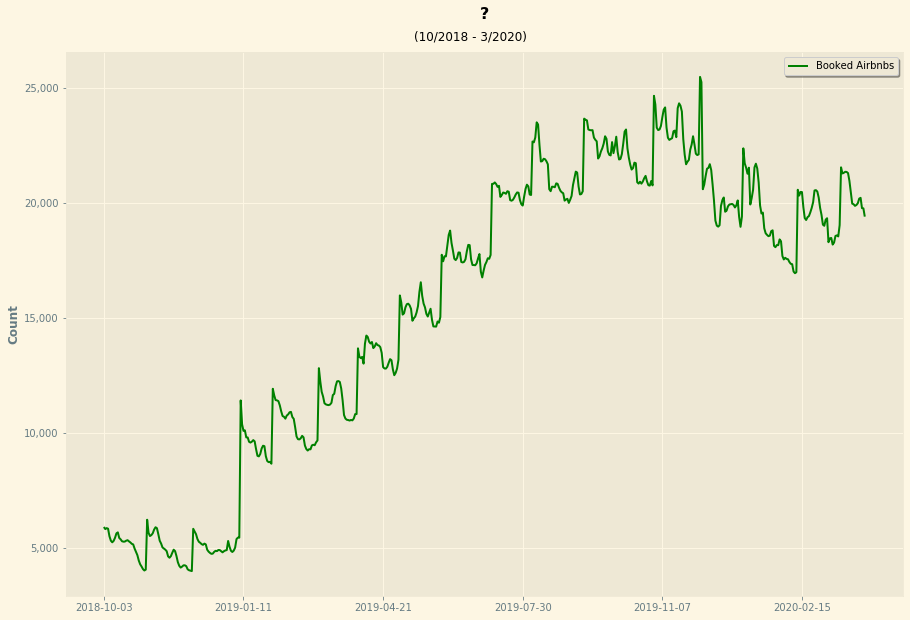

In [10]:
#Set figure size
fig, ax = plt.subplots(figsize = (15,10))
#Visualize airbnbs data
g = bookings_df.plot(y = 'count', ax=ax, color = 'g')

###Set plot Aesthetics###
#Title
ax.set_title('?', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
ax.set_ylabel('Count', fontdict = label_dict)
ax.set_xlabel('')

#Legend
ax.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)

**Decompose Original Time-Series Data**

In [11]:
#Convert index to DateTimeIndex
bookings_df.reset_index(inplace=True)
bookings_df.date = pd.to_datetime(bookings_df.date)
bookings_df.set_index('date', inplace=True)

#Check
display(bookings_df.head())

,count
date,
2018-10-03,5897
2018-10-04,5806
2018-10-05,5847
2018-10-06,5822
2018-10-07,5493


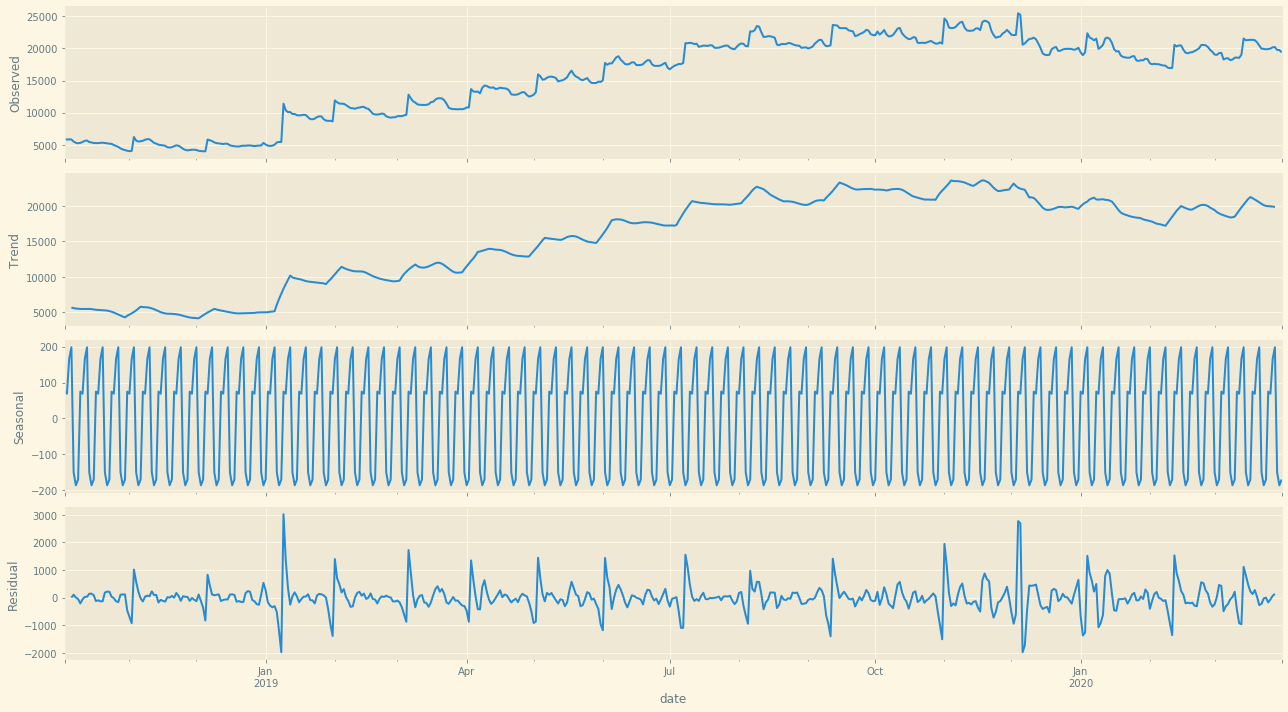

In [12]:
#Read in seasonal decompose model
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

#Fit seasonal_decompose to airbnb data
result = seasonal_decompose(bookings_df, model='additive')

#Plot
result.plot();

## Removing Non-Stationarity

### Detrend Data

**Prepare Data**

In [13]:
#Apply seasonal_decompose to count of bookings_df
result_add = seasonal_decompose(bookings_df['count'], model= 'additive',extrapolate_trend='freq')

#Detrend bookings_df['count']
detrended = bookings_df['count'] - result_add.trend

**Plot detrended time series**

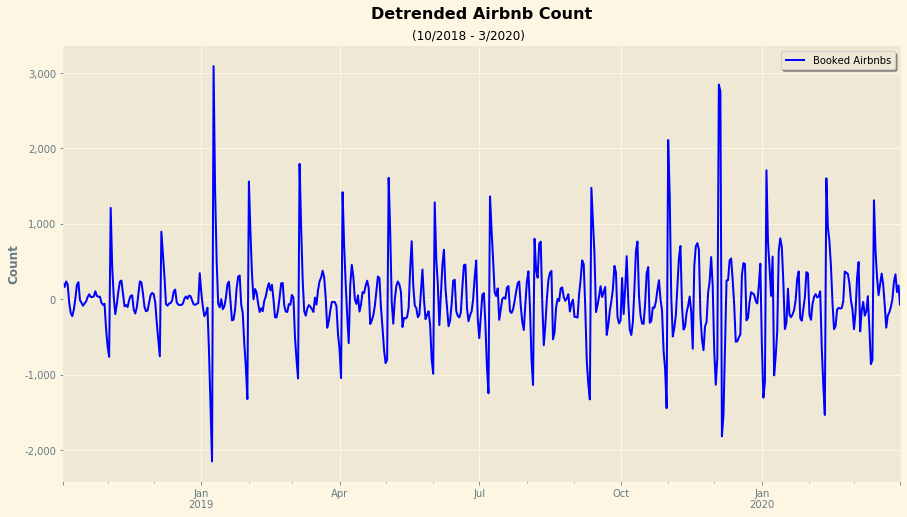

In [14]:
#Set figure
fig, ax = plt.subplots(figsize = (15,8))

#Plot detrended data
g = detrended.plot(color = 'blue', ax = ax)

###Set plot Aesthetics###
#Title
g.set_title('Detrended Airbnb Count', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
g.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
g.set_ylabel('Count', fontdict = label_dict)
g.set_xlabel('')

#Legend
g.legend(labels = ['Booked Airbnbs', 'Smoothed Weekly Avg', 'Smoothed Weekly SD'],frameon = True, shadow = True)

### Remove Seasonality

### Checks for Stationarity

**Augmented Dickey-Fuller test**

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [15]:
#Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

#Implement on detrended timeseries
result  = adfuller(detrended)

#Print results
print('ADF Statistic: {}'.format(round(result[0], 4)))
print('P-Value: {}'.format(result[1]))
print('Critical Values: ')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.9395
P-Value: 9.376500579803e-20
Critical Values: 
	1%: -3.443
	5%: -2.867
	10%: -2.570


### Reducing Noise with smoothing

**Rolling average(1 week)

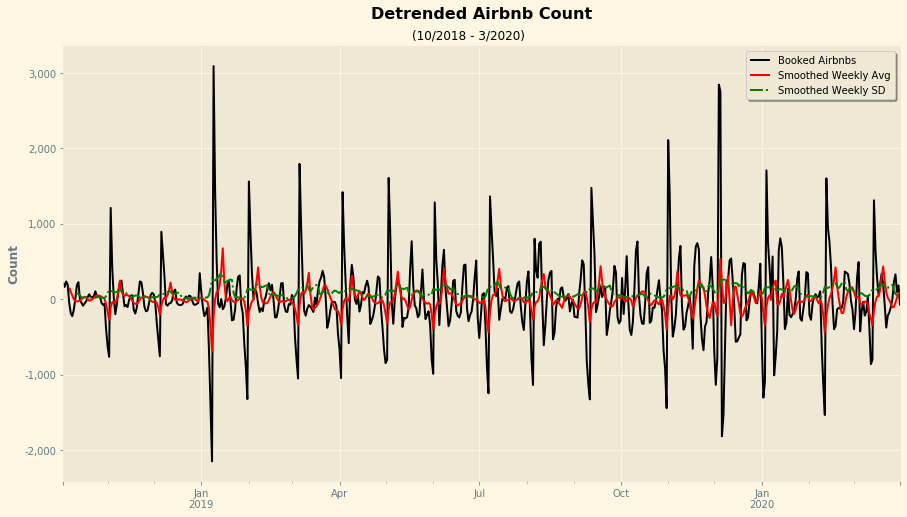

In [16]:
#Set figure
fig, ax = plt.subplots(figsize = (15,8))

#Plot detrended data
g = detrended.plot(color = 'black', ax = ax)

#Plot Weekly smoothing
smooth_detrended = detrended.rolling(7, min_periods = 5).mean()
j = smooth_detrended.plot(color = 'r',ax=ax)
k = smooth_detrended.rolling(7, min_periods = 5).std().plot(linestyle = '-.', color = 'green',ax=ax)



###Set plot Aesthetics###
#Title
g.set_title('Detrended Airbnb Count', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
g.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
g.set_ylabel('Count', fontdict = label_dict)
g.set_xlabel('')

#Legend
g.legend(labels = ['Booked Airbnbs', 'Smoothed Weekly Avg', 'Smoothed Weekly SD'],frameon = True, shadow = True)

**Prep smoothing with rolling averahe and LOESS(Localized Regression) Smoothing**

In [ ]:
smooth_detrended = detrended.rolling(7, min_periods = 5).mean()


In [17]:
#Read in LOESS
from statsmodels.nonparametric.smoothers_lowess import lowess

#5% smoothing
detrended_loess_5 = pd.DataFrame(lowess(detrended.values, np.arange(len(detrended.values)), frac=.05)[:,1], 
                                 index=detrended.index, columns=['smoothed_value'])

#15% smoothing
detrended_loess_15= pd.DataFrame(lowess(detrended.values, np.arange(len(detrended.values)),frac=.15)[:,1], 
                                 index= detrended.index, columns=['smoothed_values'])



**Plot Data**

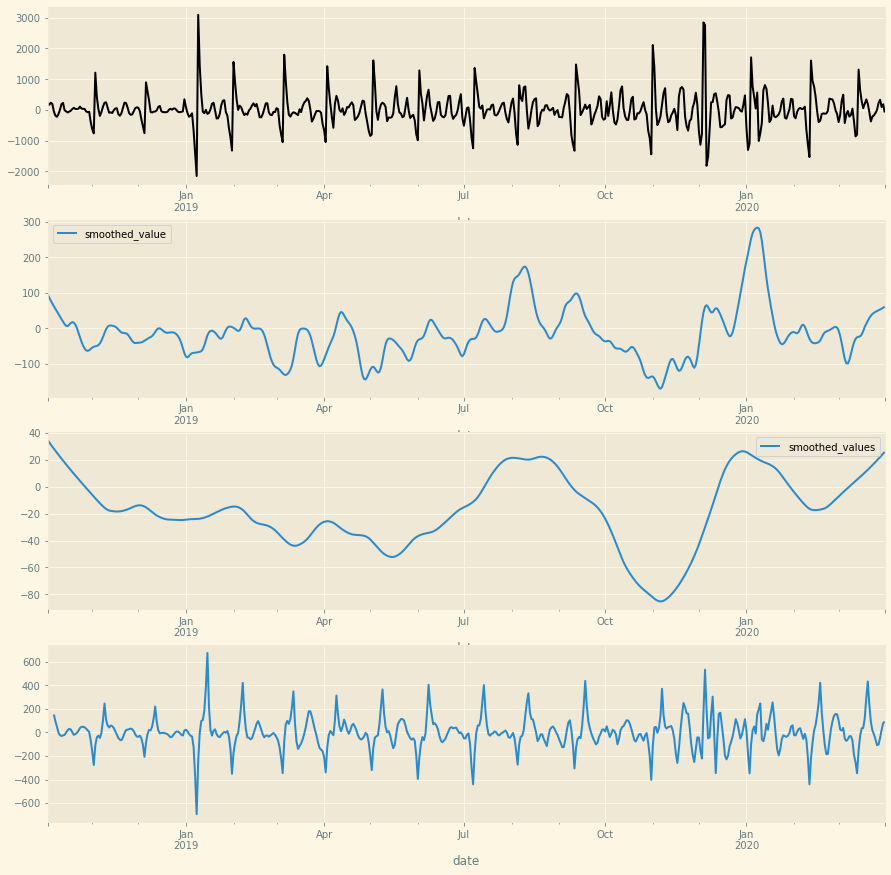

In [20]:
#Create figure
fig, ax = plt.subplots(4, 1, figsize = (15,15))

#Plot Data
detrended.plot(color = 'black', ax = ax[0])
detrended_loess_5.plot(ax = ax[1])

detrended_loess_15.plot(ax = ax[2])

smooth_detrended.plot(ax = ax[3])


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

### Apply models for forcasting

Split data


In [39]:
cutoff = round(len(detrended)*.8)

In [40]:
train = detrended[:cutoff]
test = detrended[cutoff:]

In [45]:
print(len(detrended))
print(train.shape)
print(test.shape)

546
(437,)
(109,)


Implement Smoothing Models

Forecasting with ARIMA

Finding ARIMA parameters

How much differencing to apply

D = 0, detrended data is already stationary

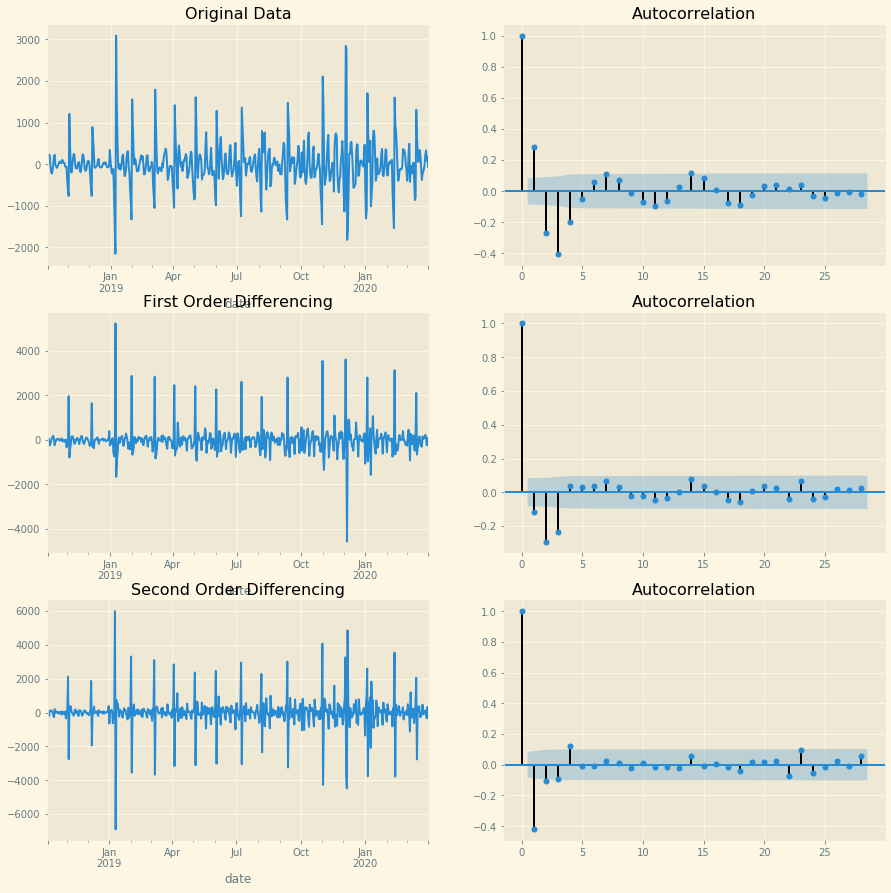

In [75]:
#Import libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Set figure
fig, axes= plt.subplots(3,2,figsize = (15,15))

#Plot Original Detrended Data and associated plot_acf
detrended.plot(ax=axes[0,0], title = 'Original Detrended Data')
plot_acf(detrended, ax = axes[0,1]);

#Apply and plot first differencing
detrended.diff().dropna().plot(ax = axes[1,0], title = 'First Order Differencing')
plot_acf(detrended.diff().dropna(), ax = axes[1,1]);

#Apply and plot second differencing
detrended.diff().diff().dropna().plot(ax = axes[2,0], title = 'Second Order Differencing')
plot_acf(detrended.diff().diff().dropna(), ax = axes[2,1]);


find the order of the AR term (p) using the Partial Autocorrelation (PACF) plot.


Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

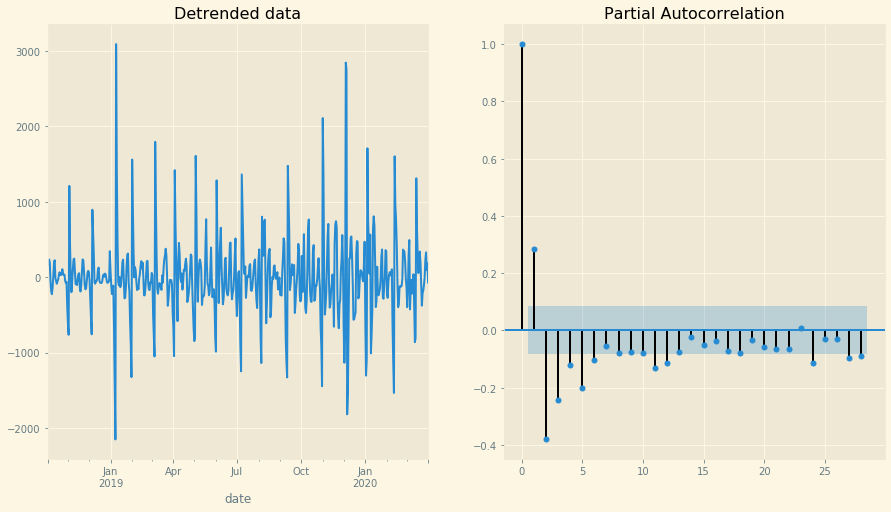

In [80]:
#Set plot
fig, ax = plt.subplots(1,2,figsize = (15,8))

#Plot Detrended data
detrended.plot(ax=ax[0], title = 'Detrended data')

#Plot pacf
plot_pacf(detrended, ax = ax[1]);

In [46]:
#Import ARIMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Init ARIMA model
arima_model = pm.auto_arima(train,start_p=1, start_q=1,
                           test = 'adf',
                           max_p=3, max_q=3,
                           seasonal=False, d = None,
                            n_jobs=-1, start_P = 0, trace=True,
                            error_action='ignore', suppress_warnings=True)

c:\users\kishe\miniconda3\envs\timeseries\lib\site-packages\pmdarima\arima\auto.py:229: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: order=(1, 0, 1); AIC=6666.024, BIC=6682.344, Fit time=0.153 seconds
Fit ARIMA: order=(0, 0, 0); AIC=6723.232, BIC=6731.392, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=6691.541, BIC=6703.781, Fit time=0.048 seconds
Fit ARIMA: order=(0, 0, 1); AIC=6664.815, BIC=6677.055, Fit time=0.039 seconds
Fit ARIMA: order=(0, 0, 2); AIC=6632.520, BIC=6648.839, Fit time=0.224 seconds
Fit ARIMA: order=(1, 0, 3); AIC=6533.258, BIC=6557.737, Fit time=0.251 seconds
Fit ARIMA: order=(0, 0, 3); AIC=6537.531, BIC=6557.931, Fit time=0.283 seconds
Fit ARIMA: order=(2, 0, 3); AIC=6526.369, BIC=6554.929, Fit time=0.336 seconds
Fit ARIMA: order=(2, 0, 2); AIC=6525.945, BIC=6550.424, Fit time=0.220 seconds
Fit ARIMA: order=(3, 0, 3); AIC=6528.177, BIC=6560.817, Fit time=0.519 seconds
Fit ARIMA: order=(1, 0, 2); AIC=6556.580, BIC=6576.979, Fit time=0.218 seconds
Fit ARIMA: order=(3, 0, 2); AIC=6527.001, BIC=6555.560, Fit time=0.639 seconds
Fit ARIMA: order=(2, 0, 1); AIC=6527.402, BIC=6547.8

In [47]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  437
Model:                     ARMA(2, 2)   Log Likelihood               -3256.972
Method:                       css-mle   S.D. of innovations            414.690
Date:                Tue, 21 Apr 2020   AIC                           6525.945
Time:                        13:28:51   BIC                           6550.424
Sample:                             0   HQIC                          6535.605
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2358      0.351      0.673      0.501      -0.451       0.923
ar.L1.y        0.9195      0.076     12.077      0.000       0.770       1.069
ar.L2.y       -0.4357      0.063     -6.928      0.0

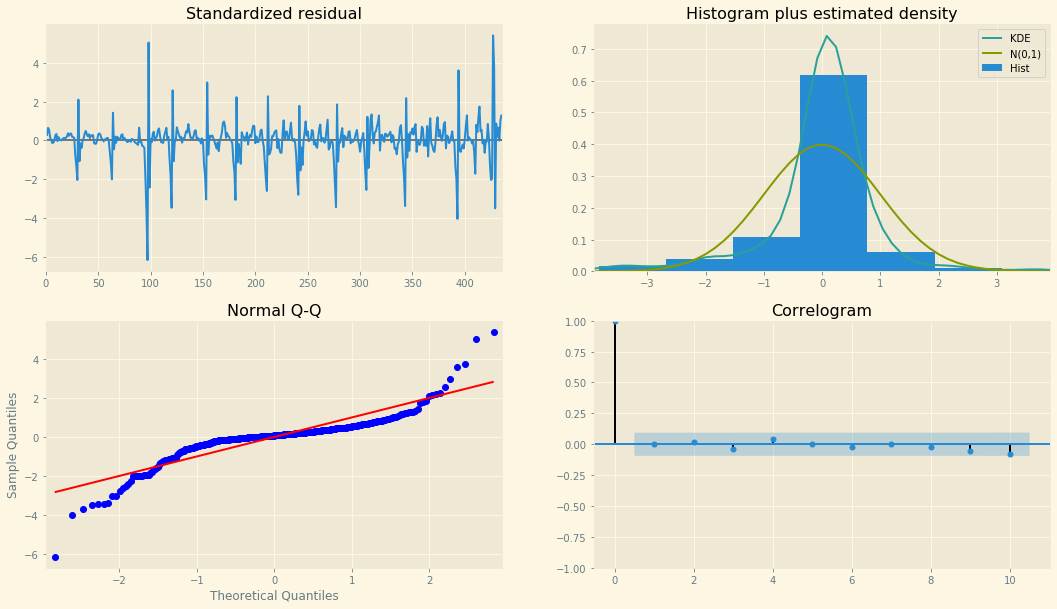

In [48]:
arima_model.plot_diagnostics();

AttributeError: 'ARIMA' object has no attribute 'plot'

Implement Prophet Model

# Time Series Analysis - Rental Income

## Quick Exploratory Data Analysis